In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.dates as mdates
import numpy as np

import intake


from functions_collector import xr_pearsonr          # computes r and p given two xarrays
from functions_collector import gaussian_filter_nan  # very useful for filtering in time



In [3]:
%load_ext autoreload
%autoreload 2

In [3]:

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")

wxt = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt = wxt.sel(time=slice('2020-01-01','2020-02-23'))

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
## radiosoundings

level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"

rs_eureca = xr.open_dataset(level2_path)
rs_eureca
rs_eureca_bco = rs_eureca.where(rs_eureca.platform==1, drop=True)

In [81]:
rs_eureca_bco

<xarray.Dataset> Size: 94MB
Dimensions:      (sounding: 344, alt: 3100, nv: 2)
Coordinates:
  * sounding     (sounding) <U40 55kB 'BCO__ascent__13.16_-59.43__20200116205...
  * alt          (alt) int16 6kB 0 10 20 30 40 ... 30950 30960 30970 30980 30990
    flight_time  (sounding, alt) datetime64[ns] 9MB ...
    lat          (sounding, alt) float32 4MB ...
    lon          (sounding, alt) float32 4MB ...
    launch_time  (sounding) datetime64[ns] 3kB 2020-01-16T20:53:46 ... 2020-0...
Dimensions without coordinates: nv
Data variables: (12/19)
    p            (sounding, alt) float32 4MB nan nan nan ... nan nan nan
    dz           (sounding, alt) float32 4MB nan nan 0.0 3.678 ... nan nan nan
    ta           (sounding, alt) float32 4MB nan nan nan 299.9 ... nan nan nan
    dp           (sounding, alt) float32 4MB nan nan 293.6 294.2 ... nan nan nan
    wspd         (sounding, alt) float32 4MB nan nan 3.7 3.636 ... nan nan nan
    u            (sounding, alt) float32 4MB nan nan -3.619 ... nan nan nan
    ...           ...
    rh           (sounding, alt) float32 4MB nan nan nan 0.7104 ... nan nan nan
    N_ptu        (sounding, alt) float32 4MB nan nan 1.0 2.0 ... nan nan nan nan
    N_gps        (sounding, alt) float32 4MB nan nan 1.0 2.0 ... nan nan nan nan
    m_ptu        (sounding, alt) float32 4MB 0.0 0.0 0.0 2.0 ... 0.0 0.0 0.0 0.0
    m_gps        (sounding, alt) float32 4MB 0.0 0.0 2.0 2.0 ... 0.0 0.0 0.0 0.0
    ascent_flag  (sounding) float32 1kB 1.0 1.0 0.0 1.0 0.0 ... 1.0 0.0 1.0 0.0
Attributes: (12/13)
    title:            EUREC4A level 2 sounding data
    platform:         BCO
    instrument:       Radiosonde RS41-SGP by Vaisala
    doi:              10.25326/137
    created_with:     batch_interpolate_soundings.py with its last modificati...
    created_on:       Tue Dec 22 18:54:59 2020
    ...               ...
    Conventions:      CF-1.7
    campaign_id:      EUREC4A
    references:       Stephan et al. (2020): Ship- and island-based atmospher...
    acknowledgement:  The MPI-M is listed as the institute of first contact. ...
    instrument_id:    Vaisala-RS
    version:          v3.0.0

In [5]:
wxt_radio = wxt.sel(time=slice(rs_eureca_bco.launch_time[0], 
                               rs_eureca_bco.launch_time[-1]))

#### get a sense of how many Nans we are dealing with

In [6]:
asc   = (rs_eureca_bco.ascent_flag == 1) 
desc  = (rs_eureca_bco.ascent_flag == 0) 

nulls = rs_eureca_bco.isnull()
asc_nulls = nulls.where(asc, drop=True)
desc_nulls = nulls.where(desc, drop=True)


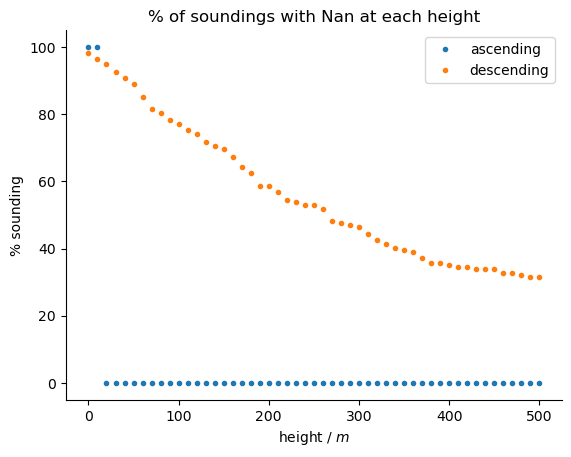

In [7]:
low, upp = 0,5e2
asc_theta_nulls = asc_nulls.theta.sel(alt=slice(low,upp))
plt.plot(asc_theta_nulls.alt, 100*asc_theta_nulls.sum(dim="sounding")/asc_theta_nulls.sounding.shape[0], ".", label="ascending")

desc_theta_nulls = desc_nulls.theta.sel(alt=slice(low,upp))
plt.plot(desc_theta_nulls.alt, 100*desc_theta_nulls.sum(dim="sounding")/desc_theta_nulls.sounding.shape[0], ".", label="descending")

plt.legend()


plt.gca().set_xlabel(r"height / $m$")
plt.gca().set_ylabel(r"% sounding")
plt.gca().set_title("% of soundings with Nan at each height")
plt.gca().legend()

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

#### compare radio with surface wind

In [8]:
smooth_wind_wxt_radio = xr.apply_ufunc(
        gaussian_filter_nan,
        wxt_radio.VEL.chunk({'time': -1}),
        kwargs={'sigma': 60, 'axis': 0, 'truncate': 4.0},
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[wxt_radio.VEL.dtype]
    )

p EU under 5% True


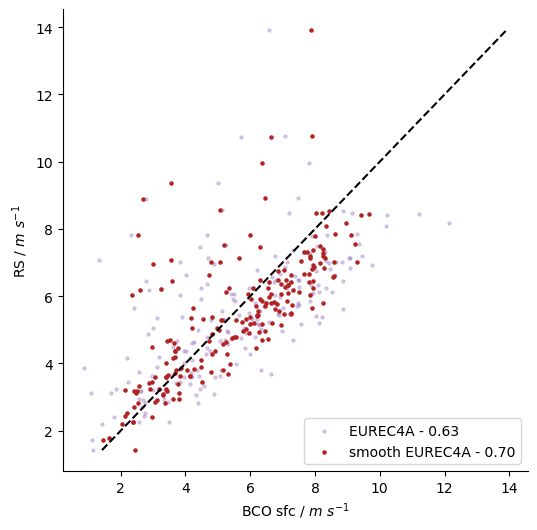

In [7]:
x        = wxt_radio.VEL.sel(time=rs_eureca_bco.launch_time, method='nearest')
smooth_x = smooth_wind_wxt_radio.sel(time=rs_eureca_bco.launch_time, method='nearest')
y        = rs_eureca_bco.wspd.sel(alt=slice(0,50)).mean(dim="alt")

r_eu, p_eu = xr_pearsonr(x, y, dim="sounding")
smooth_r_eu, smooth_p_eu = xr_pearsonr(smooth_x, y, dim="sounding")


fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(x, y,   s=5, color="tab:purple",  label=f"EUREC4A - {r_eu.values:.2f}", alpha=0.3)
ax.scatter(smooth_x,   y, s=5, color="firebrick",  label=f"smooth EUREC4A - {smooth_r_eu.values:.2f}")

# - 1-to-1 line
ax.plot([y.min().values, y.max().values], [y.min().values, y.max().values], "--k")




ax.set_xlabel(r"BCO sfc / $m~s^{-1}$")
ax.set_ylabel(r"RS / $m~s^{-1}$")
ax.legend()

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

print(f"p EU under 5% {p_eu.values < 0.05}")



#### compare T,q with surface T,q

In [6]:
temp = wxt_radio['T'] + 273.15  ## deg K
rh   = wxt_radio['RH']/100.     ## values betwen 0 and 1
sfc_pressure = wxt_radio['P']   ## already in hPa

wxt_theta = temp*((1000/sfc_pressure)**(0.286))

from functions_collector import mr_from_rh

wxt_mr = mr_from_rh(temp, sfc_pressure, rh)


In [7]:
smooth_mr_wxt_radio = xr.apply_ufunc(
        gaussian_filter_nan,
        wxt_mr.chunk({'time': -1}),
        kwargs={'sigma': 60, 'axis': 0, 'truncate': 4.0},
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[wxt_mr.dtype]
    )

smooth_theta_wxt_radio = xr.apply_ufunc(
        gaussian_filter_nan,
        wxt_theta.chunk({'time': -1}),
        kwargs={'sigma': 60, 'axis': 0, 'truncate': 4.0},
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[wxt_theta.dtype]
    )

p Theta under 5% True
p MR under 5% True


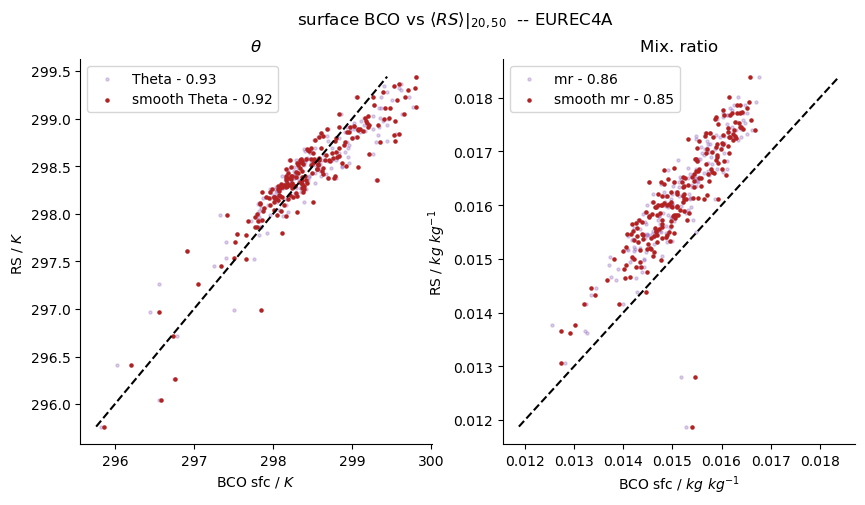

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
low, upp = [20, 50]
fig.suptitle(fr"surface BCO vs $\langle RS \rangle |_{{{low},{upp}}}$  -- EUREC4A")


## potential temperature
x        = wxt_theta.sel(time=rs_eureca_bco.launch_time, method='nearest')
smooth_x = smooth_theta_wxt_radio.sel(time=rs_eureca_bco.launch_time, method='nearest')
y        = rs_eureca_bco.theta.sel(alt=slice(low,upp)).mean(dim="alt")

r, p = xr_pearsonr(x, y, dim="sounding")
smooth_r, smooth_p = xr_pearsonr(smooth_x, y, dim="sounding")

print(f"p Theta under 5% {p.values < 0.05}")

ax[0].scatter(x, y,   s=5, color="tab:purple",  label=f"Theta - {r.values:.2f}", alpha=0.3)
ax[0].scatter(smooth_x,   y, s=5, color="firebrick",  label=f"smooth Theta - {smooth_r.values:.2f}")

# - 1-to-1 line
ax[0].plot([y.min().values, y.max().values], [y.min().values, y.max().values], "--k")

ax[0].set_xlabel(r"BCO sfc / $K$")
ax[0].set_ylabel(r"RS / $K$")
ax[0].set_title(r"$\theta$")



## mixing ratio
x        = wxt_mr.sel(time=rs_eureca_bco.launch_time, method='nearest')
smooth_x = smooth_mr_wxt_radio.sel(time=rs_eureca_bco.launch_time, method='nearest')
y        = rs_eureca_bco.mr.sel(alt=slice(low,upp)).mean(dim="alt")

r, p = xr_pearsonr(x, y, dim="sounding")
smooth_r, smooth_p = xr_pearsonr(smooth_x, y, dim="sounding")

print(f"p MR under 5% {p.values < 0.05}")

ax[1].scatter(x, y,   s=5, color="tab:purple",  label=f"mr - {r.values:.2f}", alpha=0.3)
ax[1].scatter(smooth_x,   y, s=5, color="firebrick",  label=f"smooth mr - {smooth_r.values:.2f}")

# - 1-to-1 line
ax[1].plot([y.min().values, y.max().values], [y.min().values, y.max().values], "--k")

ax[1].set_xlabel(r"BCO sfc / $kg~kg^{-1}$")
ax[1].set_ylabel(r"RS / $kg~kg^{-1}$")
ax[1].set_title(r"Mix. ratio")


for axis in ax:
    axis.legend()

    for spine in ['top', 'right']:
        axis.spines[spine].set_visible(False)


In [9]:
nulls = rs_eureca_bco.theta.isnull().sel(alt=50)
af = rs_eureca_bco.ascent_flag.sel(sounding=nulls.sounding)

condition = (nulls) & (af == 1)
bool(condition.all())

False

#### where are all these Nans coming from?

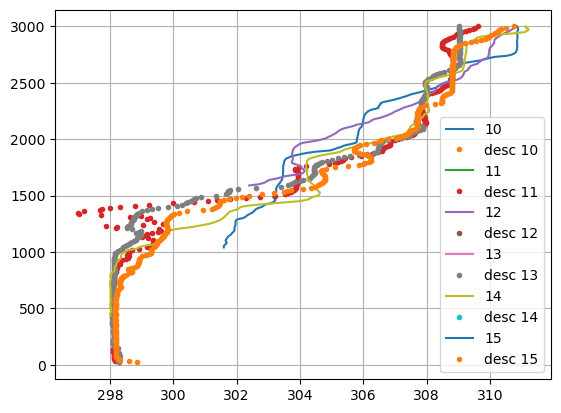

In [39]:
fig, ax = plt.subplots(1,1)
nulls = rs_eureca_bco.theta.isnull().sel(alt=50)
asc   = (rs_eureca_bco.ascent_flag == 0) 
desc  = (rs_eureca_bco.ascent_flag == 1) 

for i in range(10,16):
    val_asc = rs_eureca_bco.theta.where(asc).sel(alt=slice(0,3e3), sounding=nulls.sounding[i])
    val_desc = rs_eureca_bco.theta.where(desc).sel(alt=slice(0,3e3), sounding=nulls.sounding[i])
    ax.plot(val_asc, val_asc.alt,"-", label=f"{i}")
    ax.plot(val_desc, val_desc.alt,".", label=f"desc {i}")

ax.grid()
ax.legend()

In [37]:
rs_eureca_bco

<xarray.Dataset> Size: 94MB
Dimensions:      (sounding: 344, alt: 3100, nv: 2)
Coordinates:
  * sounding     (sounding) <U40 55kB 'BCO__ascent__13.16_-59.43__20200116205...
  * alt          (alt) int16 6kB 0 10 20 30 40 ... 30950 30960 30970 30980 30990
    flight_time  (sounding, alt) datetime64[ns] 9MB ...
    lat          (sounding, alt) float32 4MB ...
    lon          (sounding, alt) float32 4MB ...
    launch_time  (sounding) datetime64[ns] 3kB 2020-01-16T20:53:46 ... 2020-0...
Dimensions without coordinates: nv
Data variables: (12/19)
    p            (sounding, alt) float32 4MB nan nan nan ... nan nan nan
    dz           (sounding, alt) float32 4MB nan nan 0.0 3.678 ... nan nan nan
    ta           (sounding, alt) float32 4MB nan nan nan 299.9 ... nan nan nan
    dp           (sounding, alt) float32 4MB nan nan 293.6 294.2 ... nan nan nan
    wspd         (sounding, alt) float32 4MB nan nan 3.7 3.636 ... nan nan nan
    u            (sounding, alt) float32 4MB nan nan -3.619 ... nan nan nan
    ...           ...
    rh           (sounding, alt) float32 4MB nan nan nan 0.7104 ... nan nan nan
    N_ptu        (sounding, alt) float32 4MB nan nan 1.0 2.0 ... nan nan nan nan
    N_gps        (sounding, alt) float32 4MB nan nan 1.0 2.0 ... nan nan nan nan
    m_ptu        (sounding, alt) float32 4MB 0.0 0.0 0.0 2.0 ... 0.0 0.0 0.0 0.0
    m_gps        (sounding, alt) float32 4MB 0.0 0.0 2.0 2.0 ... 0.0 0.0 0.0 0.0
    ascent_flag  (sounding) float32 1kB 1.0 1.0 0.0 1.0 0.0 ... 1.0 0.0 1.0 0.0
Attributes: (12/13)
    title:            EUREC4A level 2 sounding data
    platform:         BCO
    instrument:       Radiosonde RS41-SGP by Vaisala
    doi:              10.25326/137
    created_with:     batch_interpolate_soundings.py with its last modificati...
    created_on:       Tue Dec 22 18:54:59 2020
    ...               ...
    Conventions:      CF-1.7
    campaign_id:      EUREC4A
    references:       Stephan et al. (2020): Ship- and island-based atmospher...
    acknowledgement:  The MPI-M is listed as the institute of first contact. ...
    instrument_id:    Vaisala-RS
    version:          v3.0.0

### classify profiles based on windspeed

In [6]:
rs_eureca_bco.sounding[0].launch_time

<xarray.DataArray 'launch_time' ()> Size: 8B
array('2020-01-16T20:53:46.000000000', dtype='datetime64[ns]')
Coordinates:
    launch_time  datetime64[ns] 8B 2020-01-16T20:53:46
    sounding     <U40 160B 'BCO__ascent__13.16_-59.43__202001162053'
Attributes:
    long_name:  time at which the sounding started

In [4]:
# --- things I will need later
cp = 1004   # J / Kg K
Lv = 2.5e6  # J / Kg
grav  = 9.81   # m / s^2

## open EUREC4A soundings dataset - selecting only ascending RS from BCO
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"

rs_eureca = xr.open_dataset(level2_path)
rs_eureca_bco = rs_eureca.where((rs_eureca.platform==1)&(rs_eureca["ascent_flag"]==1) , drop=True)

# select profiles above 20 m
rs_eureca_bco = rs_eureca_bco.where(rs_eureca_bco.alt>20, drop=True)

# RENAME sounding into LAUNCH_TIME
rs_eureca_bco = rs_eureca_bco.swap_dims({"sounding": "launch_time"})


## open BCO surface wind speed
import intake
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


import pandas as pd

start, end = rs_eureca_bco.launch_time[0] - pd.Timedelta("2H"), rs_eureca_bco.launch_time[-1] + pd.Timedelta("2H")

wxt = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt_radio = wxt.sel(time=slice(start,end))


/tmp/ipykernel_1869450/319756549.py:26: Pandas4Warning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  start, end = rs_eureca_bco.launch_time[0] - pd.Timedelta("2H"), rs_eureca_bco.launch_time[-1] + pd.Timedelta("2H")
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
vel = wxt_radio["VEL"]
hourly_vel = wxt_radio["VEL"].resample(time="1h").mean()

temp = wxt_radio['T'].resample(time="1h").mean() + 273.15    ## deg K
rh   = (wxt_radio['RH']/100.).resample(time="1h").mean()     ## values betwen 0 and 1

sfc_pressure = wxt_radio['P'].resample(time="1h").mean()    ## already in hPa
from functions_collector import mr_from_rh

# temp is already in Kelvin
# press is already in mb
# rh was converted between 0 nd 1
mr = mr_from_rh(temp, sfc_pressure, rh)

Text(0.5, 1.0, 'Hourly wind speed and RS launches')

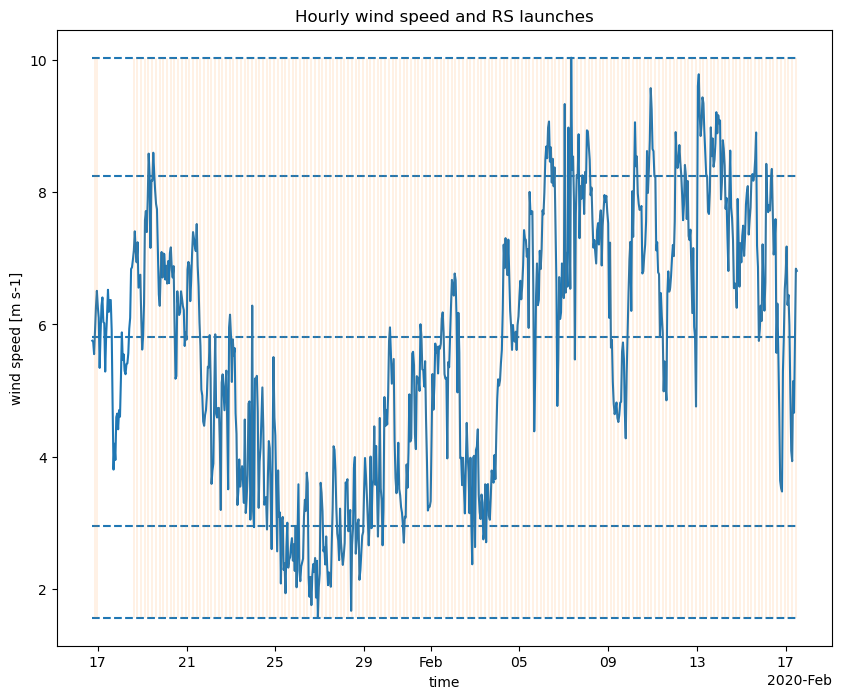

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

hourly_vel.plot.line(ax=ax, x="time")
qs = hourly_vel.quantile([0, 0.1, 0.5, 0.9, 1.0])

# Horizontal lines across full time range
ax.hlines(
    y=qs.values,
    xmin=hourly_vel.time.min().values,
    xmax=hourly_vel.time.max().values,
    linestyles="dashed",
)

ax.vlines(
    x=rs_eureca_bco.launch_time.values,
    ymin=float(hourly_vel.min()),
    ymax=float(hourly_vel.max()),
    color="tab:orange",
    linewidths=0.15
)



ax.set_title(r"Hourly wind speed and RS launches")

In [71]:
mse_prf     = cp*rs_eureca_bco["ta"] + Lv*rs_eureca_bco["mr"] + grav*rs_eureca_bco["mr"].alt
sat_mse_prf = cp*rs_eureca_bco["ta"] + (Lv*rs_eureca_bco["mr"] / rs_eureca_bco["rh"]) + grav*rs_eureca_bco["mr"].alt

sfc_mse, sfc_sat_mse = cp*temp + Lv*mr ,  cp*temp + Lv*mr/rh

mse_prf, sat_mse_prf = mse_prf.where(mse_prf.alt>20, drop=True), sat_mse_prf.where(sat_mse_prf.alt>20, drop=True)

In [72]:
quantile_ranges = {'low': [0.00, 0.10], 'mid': [0.45, 0.55], 'high': [0.90, 1.00]}
resulting_wind_bins = {'low': [], 'mid': [], 'high': []}
mse_prf_eu, sat_mse_prf_eu, rh_prf_eu = {}, {}, {}
sfc_mse_eu, sfc_sat_mse_eu, sfc_rh_eu = {}, {}, {}

## add also profiles of RH and saturated MSE

for key, (q_low, q_high) in quantile_ranges.items():
    q_min, q_max = hourly_vel.quantile([q_low, q_high]).values
    resulting_wind_bins[key] = [q_min, q_max]
    mask = ((hourly_vel >= q_min) & (hourly_vel <= q_max)).compute()
    valid_times = hourly_vel.time.where(mask, drop=True)

    ## select nearest profiles to hourly wind estimates
    mse_prf_eu[key] = mse_prf.sel(launch_time=valid_times.values, method="nearest")
    sat_mse_prf_eu[key] = sat_mse_prf.sel(launch_time=valid_times.values, method="nearest")
    rh_prf_eu[key] = rs_eureca_bco["rh"].sel(launch_time=valid_times.values, method="nearest")

    ## surface values for reference
    sfc_mse_eu[key] = sfc_mse.sel(time=valid_times.values, method="nearest")
    sfc_sat_mse_eu[key] = sfc_sat_mse.sel(time=valid_times.values, method="nearest")
    sfc_rh_eu[key] = rh.sel(time=valid_times.values, method="nearest")

# low_mse_prof_as = mse_prf_orc['low']
# mid_mse_prof_as = mse_prf_orc['mid']
# high_mse_prof_as = mse_prf_orc['high']

In [73]:
mse_prf_eu_median, sat_mse_prf_eu_median, rh_prf_eu_median = {}, {}, {}
sfc_mse_eu_median, sfc_sat_mse_eu_median, sfc_rh_eu_median = {}, {}, {}

median_wind = hourly_vel.quantile(0.5).values
mask_above = (hourly_vel >= median_wind).compute()
mask_below = (hourly_vel < median_wind).compute()
times_above = hourly_vel.time.where(mask_above, drop=True)
times_below = hourly_vel.time.where(mask_below, drop=True)

## select profiles based on median
mse_prf_eu_median["below"] = mse_prf.sel(launch_time=times_below.values, method="nearest")
mse_prf_eu_median["above"] = mse_prf.sel(launch_time=times_above.values, method="nearest")

sat_mse_prf_eu_median["below"] = sat_mse_prf.sel(launch_time=times_below.values, method="nearest")
sat_mse_prf_eu_median["above"] = sat_mse_prf.sel(launch_time=times_above.values, method="nearest")

rh_prf_eu_median["below"] = rs_eureca_bco["rh"].sel(launch_time=times_below.values, method="nearest")
rh_prf_eu_median["above"] = rs_eureca_bco["rh"].sel(launch_time=times_above.values, method="nearest")


## surface values for reference

sfc_mse_eu_median["below"] = sfc_mse.sel(time=times_below.values, method="nearest")
sfc_mse_eu_median["above"] = sfc_mse.sel(time=times_above.values, method="nearest")

sfc_sat_mse_eu_median["below"] = sfc_sat_mse.sel(time=times_below.values, method="nearest")
sfc_sat_mse_eu_median["above"] = sfc_sat_mse.sel(time=times_above.values, method="nearest")

sfc_rh_eu_median["below"] = rh.sel(time=times_below.values, method="nearest")
sfc_rh_eu_median["above"] = rh.sel(time=times_above.values, method="nearest")

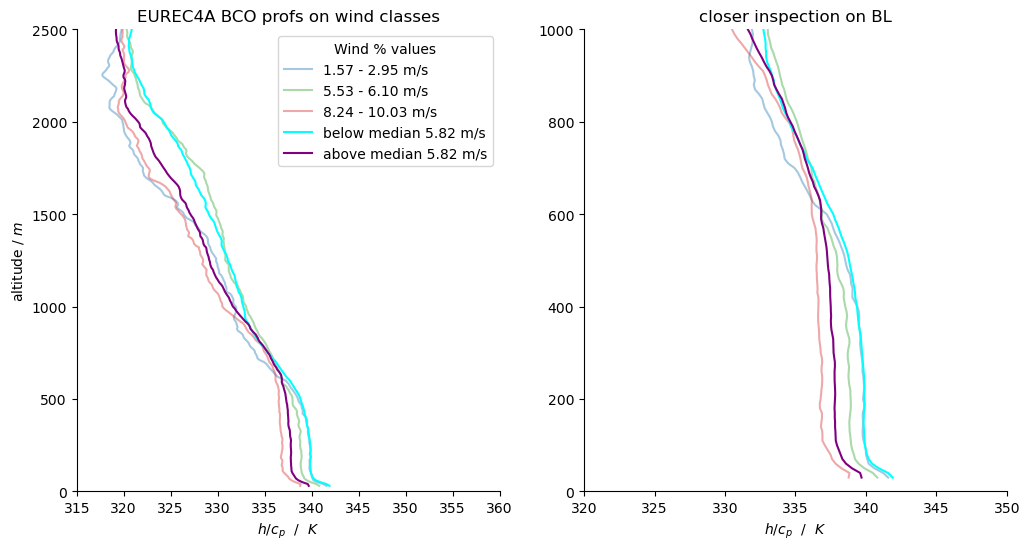

In [74]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1,2, figsize=(12,6))

cols = {"low wind":"tab:blue",
        "mid wind":"tab:green",
        "high wind":"tab:red"}

## percentile based
(mse_prf_eu['low']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["low"][0]:.2f} - {resulting_wind_bins["low"][1]:.2f} m/s", color=cols['low wind'], alpha=0.4)
(mse_prf_eu['mid']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["mid"][0]:.2f} - {resulting_wind_bins["mid"][1]:.2f} m/s", color=cols["mid wind"], alpha=0.4)
(mse_prf_eu['high']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["high"][0]:.2f} - {resulting_wind_bins["high"][1]:.2f} m/s", color=cols["high wind"], alpha=0.4)

# median based profiles
(mse_prf_eu_median['below']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"below median {median_wind:.2f} m/s", color="cyan")
(mse_prf_eu_median['above']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"above median {median_wind:.2f} m/s", color="purple")

ax[0].set_ylim(0,2500)
ax[0].set_xlim(315,360)


## ------  closer inspection on BL  ----------
(mse_prf_eu['low']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"{resulting_wind_bins["low"][0]:.2f} - {resulting_wind_bins["low"][1]:.2f} m/s", color=cols['low wind'], alpha=0.4)
(mse_prf_eu['mid']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"{resulting_wind_bins["mid"][0]:.2f} - {resulting_wind_bins["mid"][1]:.2f} m/s", color=cols["mid wind"], alpha=0.4)
(mse_prf_eu['high']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"{resulting_wind_bins["high"][0]:.2f} - {resulting_wind_bins["high"][1]:.2f} m/s", color=cols["high wind"], alpha=0.4)

## median based profiles
(mse_prf_eu_median['below']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"below median {median_wind:.2f} m/s", color="cyan")
(mse_prf_eu_median['above']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"above median {median_wind:.2f} m/s", color="purple")

ax[1].set_ylim(0,1000)
ax[1].set_xlim(320,350)
ax[1].set_title("closer inspection on BL")
ax[1].set_ylabel(r"")



for x in ax:
        for spine in ['top', 'right']:
                x.spines[spine].set_visible(False)
                x.set_xlabel(r"$h/c_p$  /  $K$")

ax[0].set_ylabel(r"altitude / $m$")
ax[0].set_title("EUREC4A BCO profs on wind classes")
ax[0].legend(loc="upper right", title="Wind % values")



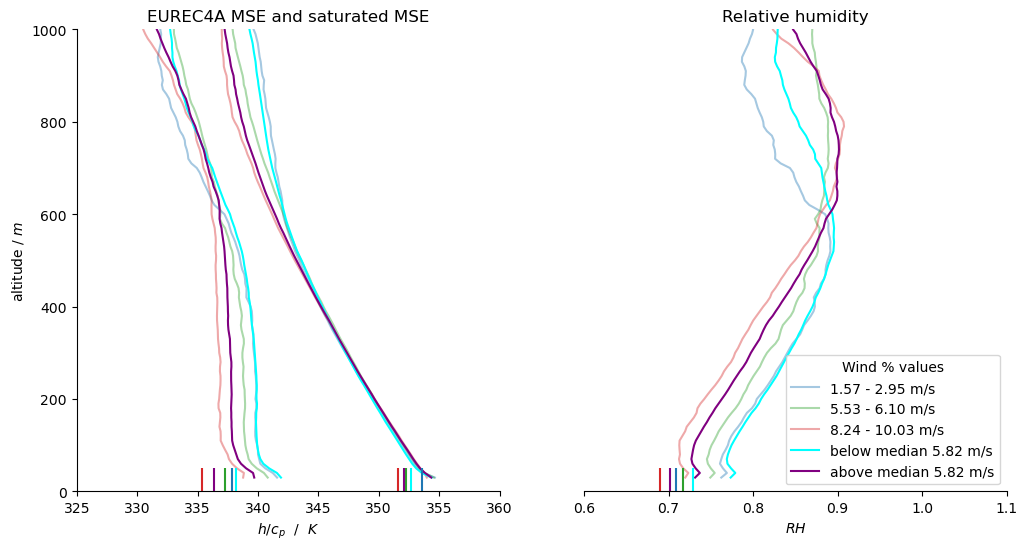

In [75]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1,2, figsize=(12,6))

cols = {"low wind":"tab:blue",
        "mid wind":"tab:green",
        "high wind":"tab:red"}


## ------  closer inspection on BL  ---------- ##

## MSE 
(mse_prf_eu['low']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["low"][0]:.2f} - {resulting_wind_bins["low"][1]:.2f} m/s", color=cols['low wind'], alpha=0.4)
(mse_prf_eu['mid']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["mid"][0]:.2f} - {resulting_wind_bins["mid"][1]:.2f} m/s", color=cols["mid wind"], alpha=0.4)
(mse_prf_eu['high']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["high"][0]:.2f} - {resulting_wind_bins["high"][1]:.2f} m/s", color=cols["high wind"], alpha=0.4)

# - median based profiles
(mse_prf_eu_median['below']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"below median {median_wind:.2f} m/s", color="cyan")
(mse_prf_eu_median['above']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"above median {median_wind:.2f} m/s", color="purple")

# surface: low, mmid, high and median
ax[0].vlines([(sfc_mse_eu["low"]/cp).mean(dim="time", skipna=True), 
              (sfc_mse_eu["mid"]/cp).mean(dim="time", skipna=True),
              (sfc_mse_eu["high"]/cp).mean(dim="time", skipna=True)], 
              ymin=0, ymax=50, 
              color = [cols["low wind"], cols["mid wind"], cols["high wind"]])

ax[0].vlines([(sfc_mse_eu_median["below"]/cp).mean(dim="time", skipna=True), 
              (sfc_mse_eu_median["above"]/cp).mean(dim="time", skipna=True)], 
              ymin=0, ymax=50, 
              color=["cyan", "purple"])



## sat MSE
(sat_mse_prf_eu['low']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["low"][0]:.2f} - {resulting_wind_bins["low"][1]:.2f} m/s", color=cols['low wind'], alpha=0.4)
(sat_mse_prf_eu['mid']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["mid"][0]:.2f} - {resulting_wind_bins["mid"][1]:.2f} m/s", color=cols["mid wind"], alpha=0.4)
(sat_mse_prf_eu['high']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"{resulting_wind_bins["high"][0]:.2f} - {resulting_wind_bins["high"][1]:.2f} m/s", color=cols["high wind"], alpha=0.4)

# - median based profiles
(sat_mse_prf_eu_median['below']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"below median {median_wind:.2f} m/s", color="cyan")
(sat_mse_prf_eu_median['above']/cp).mean(dim="launch_time", skipna=True).plot.line(ax=ax[0], y="alt", label=f"above median {median_wind:.2f} m/s", color="purple")

# surface
ax[0].vlines([(sfc_sat_mse_eu["low"]/cp).mean(dim="time", skipna=True), 
              (sfc_sat_mse_eu["mid"]/cp).mean(dim="time", skipna=True),
              (sfc_sat_mse_eu["high"]/cp).mean(dim="time", skipna=True)], 
              ymin=0, ymax=50, 
              color = [cols["low wind"], cols["mid wind"], cols["high wind"]])

ax[0].vlines([(sfc_sat_mse_eu_median["below"]/cp).mean(dim="time", skipna=True), 
              (sfc_sat_mse_eu_median["above"]/cp).mean(dim="time", skipna=True)], 
              ymin=0, ymax=50, 
              color=["cyan", "purple"])


ax[0].set_title("EUREC4A MSE and saturated MSE")
ax[0].set_xlabel(r"$h/c_p$  /  $K$")
ax[0].set_ylabel(r"altitude / $m$")
ax[0].set_xlim(325,360)




## --  RH on second axis -- ##
(rh_prf_eu['low']).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"{resulting_wind_bins["low"][0]:.2f} - {resulting_wind_bins["low"][1]:.2f} m/s", color=cols['low wind'], alpha=0.4)
(rh_prf_eu['mid']).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"{resulting_wind_bins["mid"][0]:.2f} - {resulting_wind_bins["mid"][1]:.2f} m/s", color=cols["mid wind"], alpha=0.4)
(rh_prf_eu['high']).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"{resulting_wind_bins["high"][0]:.2f} - {resulting_wind_bins["high"][1]:.2f} m/s", color=cols["high wind"], alpha=0.4)

# - median based profiles
(rh_prf_eu_median['below']).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"below median {median_wind:.2f} m/s", color="cyan")
(rh_prf_eu_median['above']).mean(dim="launch_time", skipna=True).plot.line(ax=ax[1], y="alt", label=f"above median {median_wind:.2f} m/s", color="purple")

# surface
ax[1].vlines([(sfc_rh_eu["low"]).mean(dim="time", skipna=True), 
              (sfc_rh_eu["mid"]).mean(dim="time", skipna=True),
              (sfc_rh_eu["high"]).mean(dim="time", skipna=True)], 
              ymin=0, ymax=50, 
              color = [cols["low wind"], cols["mid wind"], cols["high wind"]])

ax[1].vlines([(sfc_rh_eu_median["below"]).mean(dim="time", skipna=True), 
              (sfc_rh_eu_median["above"]).mean(dim="time", skipna=True)], 
              ymin=0, ymax=50, 
              color=["cyan", "purple"])

ax[1].set_title("Relative humidity")
ax[1].set_xlabel(r"$RH$")
ax[1].set_xlim(0.6,1.1)
ax[1].legend(loc="lower right", title="Wind % values")


ax[1].yaxis.set_visible(False)
ax[1].spines["left"].set_visible(False)
for x in ax:
        x.set_ylim(0,1000)
        for spine in ['top', 'right']:
                x.spines[spine].set_visible(False)
                

In [70]:
(sfc_mse_eu_median["above"]/cp).mean(dim="time", skipna=True).values

array(338.14325, dtype=float32)

### ceilometer data

In [5]:
path_to_ceilo = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__202001.nc"
ceilo1 = xr.open_dataset(path_to_ceilo)
path_to_ceilo = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__202002.nc"
ceilo2 = xr.open_dataset(path_to_ceilo)
ceilo = xr.concat([ceilo1, ceilo2], dim="time")

ceilo['time'] = ceilo['time'].astype('datetime64[ns]')
ceilo = ceilo.sortby('time')

import pandas as pd

start, end = rs_eureca_bco.launch_time[0] - pd.Timedelta("2H"), rs_eureca_bco.launch_time[-1] + pd.Timedelta("2H")
ceilo = ceilo.sel(time=slice(start,end ))

ceilo

/tmp/ipykernel_1867869/4236734173.py:5: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ceilo = xr.concat([ceilo1, ceilo2], dim="time")
/tmp/ipykernel_1867869/4236734173.py:12: Pandas4Warning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  start, end = rs_eureca_bco.launch_time[0] - pd.Timedelta("2H"), rs_eureca_bco.launch_time[-1] + pd.Timedelta("2H")


<xarray.Dataset> Size: 24MB
Dimensions:               (time: 282953)
Coordinates:
  * time                  (time) datetime64[ns] 2MB 2020-01-16T18:53:49.98046...
Data variables:
    YYYYMMDDHH            (time) float64 2MB 2.02e+09 2.02e+09 ... 2.02e+09
    cbh_1                 (time) float32 1MB 696.5 816.5 816.5 ... nan nan nan
    cbh_2s_1              (time) float32 1MB 794.0 899.0 899.0 ... nan nan nan
    cbh_jenoptik_1        (time) float32 1MB 776.0 884.0 884.0 ... nan nan nan
    flag_rain             (time) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lat                   (time) float64 2MB 13.16 13.16 13.16 ... 13.16 13.16
    lon                   (time) float64 2MB -59.43 -59.43 ... -59.43 -59.43
    flag_ceilo_status     (time) float64 2MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    flag_jenoptik_output  (time) float64 2MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    flag_mrr_status       (time) float64 2MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    bco_day               (time) datetime64[ns] 2MB 2020-01-16T18:53:49.98046...
Attributes: (12/13)
    title:          Cloud base height estimates and rain flag from ceilometer...
    author:         Louise Nuijens (louise.nuijens@mpimet.mpg.de)
    institution:    Max Planck Institute for Meteorology
    location:       Barbados Cloud Observatory, Deebles Point, Barbados, West...
    resolution:     Temporal resolution = 10 seconds. Vertical resolution = 1...
    details_rain:   Rain flag is 1 when rain-rate > 0.05 mm/hr in five or mor...
    ...             ...
    source:         Ceilometer profiles of backscattered photons in PR^2, cor...
    instrument:     Jenoptik CHM 15k(X) ceilometer and MeTeK micro-rain radar...
    converted_by:   Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_with:   get_cloudbaseheight.ncl with its last modification on 201...
    creation_date:  Wed Feb 12 16:05:24 CET 2020
    version:        1.1.1; git:tag 1.1.1/commit after 98d8f60d

Text(0, 0.5, 'cbh_1 (bins)')

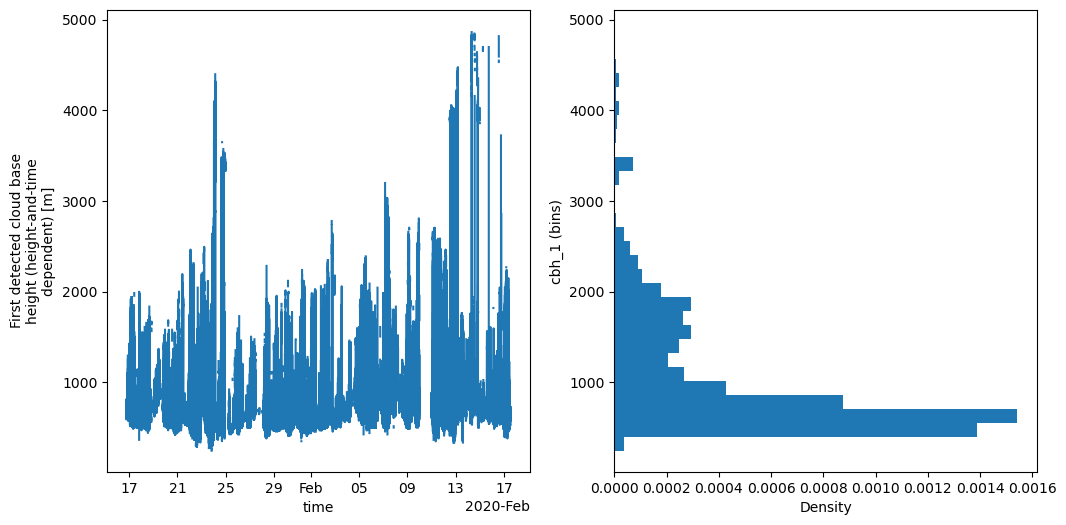

In [46]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ceilo["cbh_1"].plot(ax=ax[0], x="time")

ceilo["cbh_1"].plot.hist(
    ax=ax[1],
    bins=30,
    density=True,          # x-axis will show density
    orientation="horizontal"
)

ax[1].set_xlabel("Density")
ax[1].set_ylabel("cbh_1 (bins)")

In [6]:
# create hour-wide windows around sonde launch times

dt = pd.Timedelta("30min")

time = ceilo["cbh_1"].time
launch = rs_eureca_bco.launch_time

mask = (abs(time - launch) <= dt)    ## select ceilometer data, 60 minutes windows centred on launch_time

cbh = ceilo["cbh_1"].clip(max=1000)  ## does this clipping make sense?
rain = ceilo["flag_rain"]            ## see how frequent rain is - should check how this is computed

cbh_windowed = cbh.expand_dims(launch_time=launch).where(mask)
cbh_quantiles = cbh_windowed.quantile(
    q=[0.0, 0.02, 0.05],
    dim="time",
    skipna=True
)


rain_windowed = rain.expand_dims(launch_time=launch).where(mask)
rain_fraction = (
    (rain_windowed == 1).sum(dim="time")
    / rain_windowed.notnull().sum(dim="time")
) * 100



/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


### cloud base comparison with merged methods

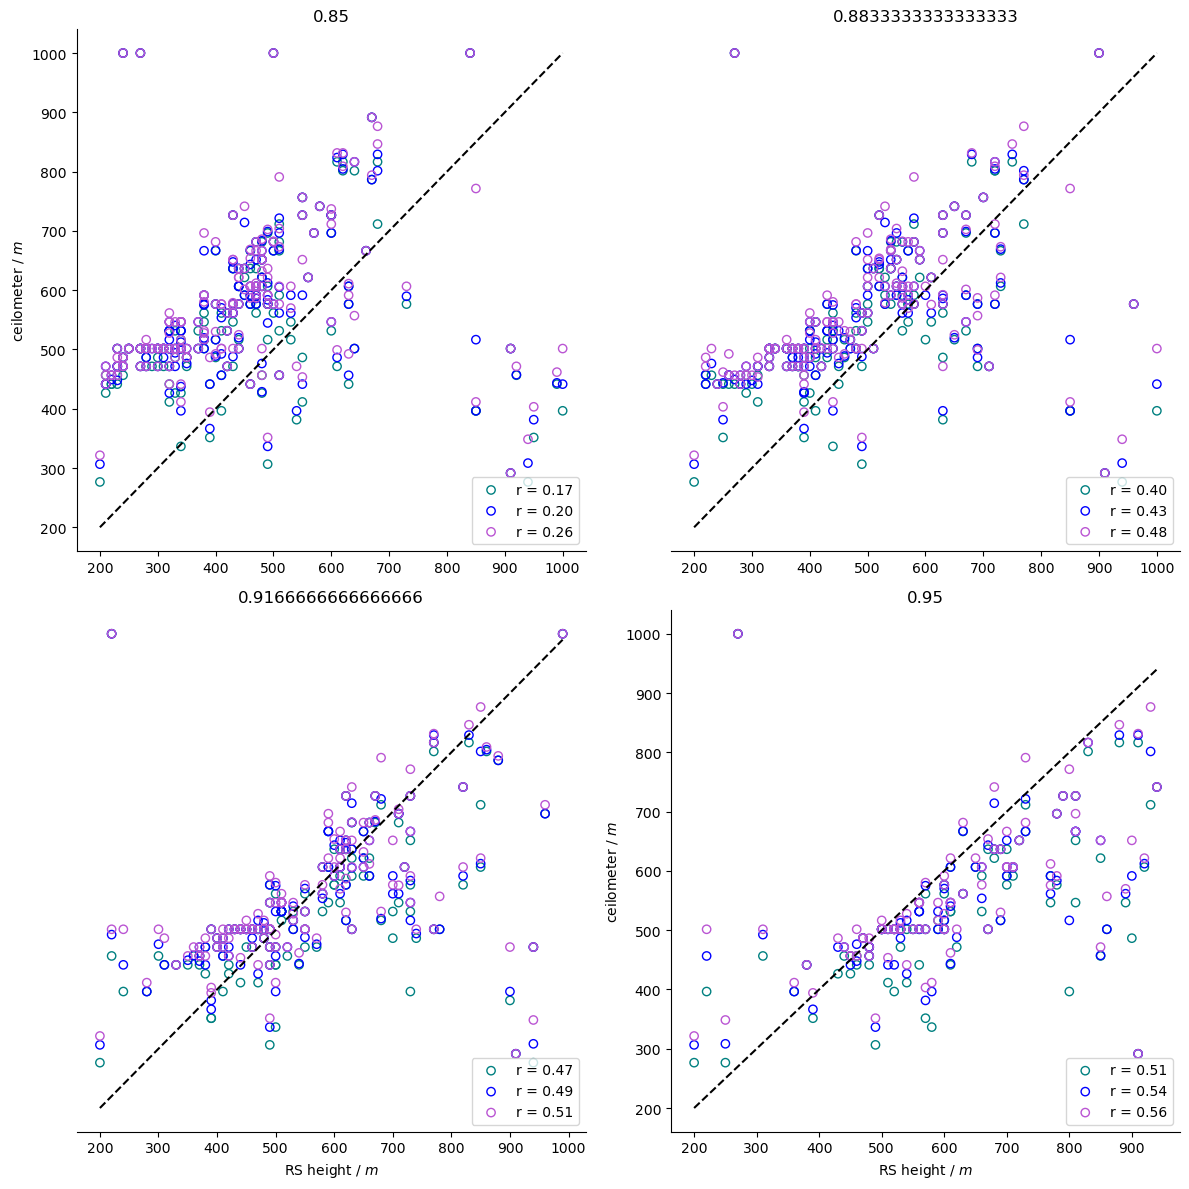

In [30]:
## compare satuartion height with ceilometer percentiles
saturation_thresh = np.linspace(0.85, 0.95, 4)

fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()

## y-values are always the same
y, y1, y2 = cbh_quantiles.isel(quantile=0), cbh_quantiles.isel(quantile=1), cbh_quantiles.isel(quantile=2)



for i, sat_val in enumerate(saturation_thresh):

    sat_rh_prf0 = rs_eureca_bco.rh.sel(alt=slice(200,1000))

    cond = (sat_rh_prf0 >= sat_val)

    sat_rh_prf = sat_rh_prf0.sel(
        launch_time=cond.any(dim="alt")
    )

    cond_sat = (sat_rh_prf >= sat_val)

    first_idx = cond_sat.idxmax(dim="alt")
    fallback_idx = sat_rh_prf.idxmax(dim="alt")

    # replace only where first_idx == 200
    # where first_idx is equal to 200, 
    # apply method 2
    first_idx = xr.where(first_idx == 200, fallback_idx, first_idx)

    ## other idea: average
    # mean_idx = (first_idx + fallback_idx)*0.5

    # lowest sat height
    x = (sat_rh_prf.alt.sel(alt=first_idx).where(cond_sat.any(dim="alt")))


    # align x and y at each step
    x_aligned, y_aligned = xr.align(x, y, join="inner")
    r, p = xr_pearsonr(x_aligned, y_aligned, "launch_time")
    axes[i].scatter(
        x_aligned,
        y_aligned,
        facecolors="none",
        edgecolors="teal", 
        label=f"r = {r:.2f}"
    )

    # align x and y at each step
    x_aligned, y1_aligned = xr.align(x, y1, join="inner")
    r1, p1 = xr_pearsonr(x_aligned, y1_aligned, "launch_time")
    axes[i].scatter(
        x_aligned,
        y1_aligned,
        facecolors="none",
        edgecolors="blue",
        label=f"r = {r1:.2f}"
    )

    # align x and y at each step
    x_aligned, y2_aligned = xr.align(x, y2, join="inner")
    r2, p2 = xr_pearsonr(x_aligned, y2_aligned, "launch_time")
    axes[i].scatter(
        x_aligned,
        y2_aligned,
        facecolors="none",
        edgecolors="mediumorchid",
        label=f"r = {r2:.2f}"
    )

    axes[i].set_title(f"{sat_val}")
    axes[i].plot([x.min().values, x.max().values], [x.min().values, x.max().values], "--k")
    axes[i].legend(loc="lower right")


for i,ax in enumerate(axes):
    if i%3 == 0 :
        ax.set_ylabel(r"ceilometer / $m$")
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
    if (i%3 != 0):
        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)
            ax.yaxis.set_visible(False)

axes[2].set_xlabel(r"RS height / $m$")
axes[3].set_xlabel(r"RS height / $m$")
# axes[8].set_xlabel(r"RS height / $m$")

plt.tight_layout()

### add LCL etimates

In [ ]:
## compute LCL here
import metpy.calc as mpcalc
from metpy.units import units

# Ensure xarray + pint units
temp_q = wxt_radio['T'].metpy.quantify()

######## debug RH ########
rh = wxt_radio['RH']
rh.attrs["units"] = "%"
rh_q = rh.metpy.quantify()
######## debug RH ########
p_q = wxt_radio['P'].metpy.quantify()

# Compute dewpoint: stays xarray with same dims
dp = mpcalc.dewpoint_from_relative_humidity(temp_q, rh_q)

# Compute LCL: returns two xarray DataArrays with same dims as temp
lcl_p, lcl_T = mpcalc.lcl(p_q, temp_q, dp)

# Convert LCL pressure to height — returns pint.Quantity, NOT xarray
lcl_h = mpcalc.pressure_to_height_std(lcl_p)

# Convert to meters
lcl_h = lcl_h.to(units.meter)

# --- FIX: rewrap into DataArray using the original coords ---
lcl_h = xr.DataArray(
    lcl_h.m,  # magnitude
    coords=temp_q.coords,
    dims=temp_q.dims,
    name='lcl_height'
)  #.metpy.quantify()  # restore pint units inside xarray

# Now resample works
lcl_h_hr = lcl_h.resample(time="1h").mean()

In [28]:
# create hour-wide windows around sonde launch times

dt = pd.Timedelta("30min")

time = lcl_h.time
launch = rs_eureca_bco.launch_time

mask = (abs(time - launch) <= dt)    ## select ceilometer data, 60 minutes windows centred on launch_time

# cbh = lcl_h.clip(max=1000)  ## does this clipping make sense?
rain = ceilo["flag_rain"]            ## see how frequent rain is - should check how this is computed

lcl_windowed = lcl_h.expand_dims(launch_time=launch).where(mask)
lcl_quantiles = lcl_windowed.quantile(
    q=[0.05, 0.5, 0.95],
    dim="time",
    skipna=True
)

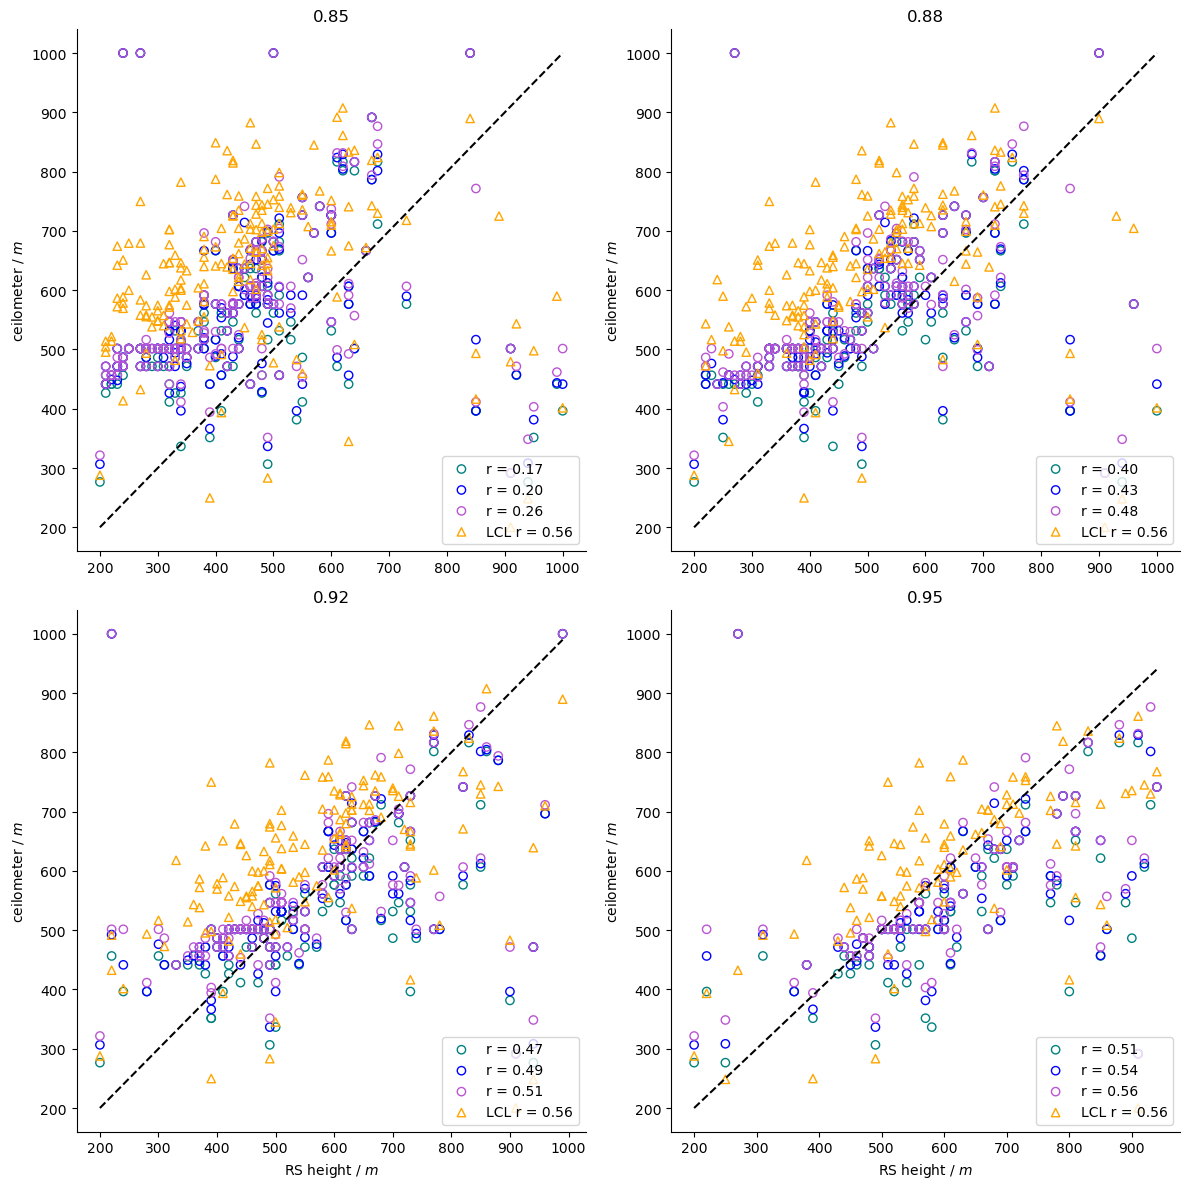

In [44]:
## compare satuartion height with ceilometer percentiles
saturation_thresh = np.linspace(0.85, 0.95, 4)

fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()

## y-values are always the same
y, y1, y2 = cbh_quantiles.isel(quantile=0), cbh_quantiles.isel(quantile=1), cbh_quantiles.isel(quantile=2)
cbh_qq_colors = ["teal", "blue", "mediumorchid"]


## LCL median values within each window
y_lcl = lcl_quantiles.isel(quantile=0) # lcl_windowed.min(dim="time") #lcl_quantiles.isel(quantile=1)


for i, sat_val in enumerate(saturation_thresh):

    sat_rh_prf0 = rs_eureca_bco.rh.sel(alt=slice(200,1000))

    cond = (sat_rh_prf0 >= sat_val)

    sat_rh_prf = sat_rh_prf0.sel(
        launch_time=cond.any(dim="alt")
    )

    cond_sat = (sat_rh_prf >= sat_val)

    first_idx = cond_sat.idxmax(dim="alt")
    fallback_idx = sat_rh_prf.idxmax(dim="alt")

    # replace only where first_idx == 200
    # where first_idx is equal to 200, 
    # apply method 2
    first_idx = xr.where(first_idx == 200, fallback_idx, first_idx)

    ## other idea: average
    # mean_idx = (first_idx + fallback_idx)*0.5

    # lowest sat height
    x = (sat_rh_prf.alt.sel(alt=first_idx).where(cond_sat.any(dim="alt")))


    for qq in range(lcl_quantiles.shape[0]):
        # align x and y at each step
        x_aligned, y_aligned = xr.align(x, cbh_quantiles.isel(quantile=qq), join="inner")
        r, p = xr_pearsonr(x_aligned, y_aligned, "launch_time")
        axes[i].scatter(
            x_aligned,
            y_aligned,
            facecolors="none",
            edgecolors=cbh_qq_colors[qq], 
            label=f"r = {r:.2f}"
        )

    # # align x and y at each step
    # x_aligned, y1_aligned = xr.align(x, y1, join="inner")
    # r1, p1 = xr_pearsonr(x_aligned, y1_aligned, "launch_time")
    # axes[i].scatter(
    #     x_aligned,
    #     y1_aligned,
    #     facecolors="none",
    #     edgecolors="blue",
    #     label=f"r = {r1:.2f}"
    # )

    # # align x and y at each step
    # x_aligned, y2_aligned = xr.align(x, y2, join="inner")
    # r2, p2 = xr_pearsonr(x_aligned, y2_aligned, "launch_time")
    # axes[i].scatter(
    #     x_aligned,
    #     y2_aligned,
    #     facecolors="none",
    #     edgecolors="mediumorchid",
    #     label=f"r = {r2:.2f}"
    # )

    # align x and y at each step
    x_aligned, y_lcl_aligned = xr.align(x, y_lcl, join="inner")
    r_lcl, p_lcl = xr_pearsonr(x_aligned, y_lcl_aligned, "launch_time")
    axes[i].scatter(
        x_aligned,
        y_lcl_aligned,
        facecolors="none",
        edgecolors="orange",
        marker="^",
        label=f"LCL r = {r2:.2f}"
    )

    axes[i].set_title(f"{sat_val:.2f}")
    axes[i].plot([x.min().values, x.max().values], [x.min().values, x.max().values], "--k")
    axes[i].legend(loc="lower right")


# for i,ax in enumerate(axes):
#     if i%3 == 0 :
#         ax.set_ylabel(r"ceilometer / $m$")
#         for spine in ['top', 'right']:
#             ax.spines[spine].set_visible(False)
#     if (i%3 != 0):
#         for spine in ['top', 'right', 'left']:
#             ax.spines[spine].set_visible(False)
#             ax.yaxis.set_visible(False)

for i,ax in enumerate(axes):
    ax.set_ylabel(r"ceilometer / $m$")
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)


axes[2].set_xlabel(r"RS height / $m$")
axes[3].set_xlabel(r"RS height / $m$")
# axes[8].set_xlabel(r"RS height / $m$")

plt.tight_layout()

### radar data for comparison?
* POLDIRAD: ds = xr.open_dataset("ipfs://bafybeiddguyq7fwtridxpbyuhyfwyhse7mx24zsy3eiwqqgdb4r5uyqary", engine="zarr").assign_coords(lat=lambda ds: ds.lat, lon=lambda ds: ds.lon)  --- this is a 2D scanning

* MBR2 cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")
mbr2 = cat.BCO.radar_MBR2_c4_v1.to_dask()\
and MBRS cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")
mbrs = cat.BCO.radar_MBRS_c1_v1.to_dask()
